In [1]:
!pip install onnx
!pip install onnxscript
!pip install onnxruntime
!pip install onnxruntime-gpu
!pip install tensorrt onnx
!pip install pycuda
!pip install torch
!pip install onnx_tensorrt
!pip install torchvision
!pip install albumentations
!pip install opencv-python
!pip install pynvml
!pip install nvidia-pyindex
!pip install gputil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.4/670.4 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.2/226.2 MB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-10.4.0-py2.py3-none-any.whl size=16337 sha256=55cacf7aa6ecc922ad7e2b49fb96bd28862f47ff9b86ca3d3444480b56682804
  Stored in directory: /root/.cache/pip/wheels/a0/19/5f/9e37c904409cb83caec8e2b682732c4cc7a74adbeda520edab
  Created wheel for tensorrt-cu12: filename=tensorrt_cu12-10.4.0-py2.py3-none-any.whl size=17554 sha256=c6fd9f2effb232a0ab6bf66a9e9a05305e2cd79652fd2fff5329e2de70ca63e9
  Stored

In [2]:
import tensorrt as trt
import onnx
import torch

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Lets define our resnet model
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 72.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
# Lets now export the model to ONNX Format
dummy_input = torch.randn(1, 3, 224, 224)
onnx_filename = "my_model.onnx"
torch.onnx.export(model, dummy_input, onnx_filename)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [38]:
# Lets load the onnx model
model_onnx = onnx.load(onnx_filename)
onnx.checker.check_model(model_onnx)
print("Yes Onnx Model Works")

Yes Onnx Model Works


In [39]:
# ENGINE BUILDING
import tensorrt as trt
import onnx

FP_16_Precision = True # If False -> Using default FP-32

# Logger for TensorRT
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

# Load the ONNX model
onnx_model_path = 'my_model.onnx'
model_onnx = onnx.load(onnx_model_path)

# Create TensorRT builder, network, and parser
builder = trt.Builder(TRT_LOGGER)
network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
parser = trt.OnnxParser(network, TRT_LOGGER)

# Parse the ONNX model
with open(onnx_model_path, 'rb') as model_file:
    if not parser.parse(model_file.read()):
        for idx in range(parser.num_errors):
            print(f"Parsing Error: {parser.get_error(idx)}")
        raise RuntimeError("Failed to parse ONNX model")

# Create optimization profile
profile = builder.create_optimization_profile()
profile.set_shape("input", (1, 3, 224, 224), (1, 3, 224, 224), (1, 3, 224, 224))  # Example shapes
builder_config = builder.create_builder_config()
builder_config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 1 << 30)

if(FP_16_Precision):
    builder_config.set_flag(trt.BuilderFlag.FP16)

# Build the engine
print("Building TensorRT engine...")
serialized_engine = builder.build_serialized_network(network, builder_config)

# Check if the engine was built successfully
if serialized_engine is None:
    raise RuntimeError("Failed to build the TensorRT engine")

# Save the engine to file
engine_file_path = 'final.engine'
with open(engine_file_path, 'wb') as f:
    f.write(serialized_engine)
print(f"Engine saved to {engine_file_path}")


Building TensorRT engine...
Engine saved to final.engine


In [40]:
del network
del builder

In [41]:
runtime = trt.Runtime(TRT_LOGGER)
engine = runtime.deserialize_cuda_engine(serialized_engine) # Deserialize engine

In [42]:
import numpy as np
import pandas as pd
import tensorrt as trt
import pycuda.autoinit
import pycuda.driver as cuda
from PIL import Image
import time
import os

In [43]:
context = engine.create_execution_context()
print("----------------TensorRT engine loaded and execution context created successfully.-----------")

----------------TensorRT engine loaded and execution context created successfully.-----------


In [44]:
trt.__version__, torch.__version__,

('10.4.0', '2.4.1+cu121')

In [45]:
def allocate_buffers(engine, batch_size):
    """
    Allocate buffers for inputs and outputs for the given TensorRT engine.

    Parameters:
    - engine: The TensorRT engine.
    - batch_size: The number of inputs to process in a single inference pass.

    Returns:
    - inputs: A list of input shapes, data types, and device pointers.
    - d_output: The device pointer for the output.
    - h_output: The host output buffer (page-locked memory).
    - bindings: List of bindings for input/output.
    - stream: The CUDA stream for managing asynchronous execution.
    """
    inputs = []
    bindings = []
    stream = cuda.Stream()

    # Iterate over each input tensor
    for i in range(engine.num_io_tensors - 1):  # Assuming last tensor is output
        tensor_name = engine.get_tensor_name(i)
        input_shape = engine.get_tensor_shape(tensor_name)
        input_size = trt.volume(input_shape) * batch_size
        dtype = trt.nptype(engine.get_tensor_dtype(tensor_name))

        # Allocate device memory for input
        d_input = cuda.mem_alloc(input_size * np.dtype(dtype).itemsize)
        inputs.append((input_shape, dtype, d_input))

        # Append to the bindings list
        bindings.append(int(d_input))

    # Allocate memory for output
    output_tensor_name = engine.get_tensor_name(engine.num_io_tensors - 1)
    output_shape = engine.get_tensor_shape(output_tensor_name)
    output_size = trt.volume(output_shape) * batch_size
    output_dtype = trt.nptype(engine.get_tensor_dtype(output_tensor_name))

    d_output = cuda.mem_alloc(output_size * np.dtype(output_dtype).itemsize)
    bindings.append(int(d_output))  # Add output binding

    # Create the host output buffer (page-locked memory) with the correct dtype
    h_output = cuda.pagelocked_empty(output_size, dtype=output_dtype)

    return inputs, d_output, h_output, bindings, stream


In [47]:
# Install the required package for GPU stats


import torch
import torchvision
import time
import GPUtil

# Load the ResNet model (or your model of choice)
model = torchvision.models.resnet50(pretrained=True).cuda()
model.eval()  # Set to evaluation mode

# Prepare dummy input
NUM_INFERENCES = 1500 # Forward Pass
batch_size = 64
dummy_input = torch.randn(batch_size, 3, 224, 224).cuda()

# Initialize variables to track inference time and store results
total_inference_time_pytorch = 0
inference_times = []  # List to store individual inference times
gpu_usage_stats = []  # List to store GPU usage for each inference

# Get GPU ID and initial memory usage
gpu_id = 0  # Change this to your GPU ID if necessary

for _ in range(NUM_INFERENCES):
    start_time = time.time()
    with torch.no_grad():  # Disable gradient calculation
        output = model(dummy_input)
    inference_time = time.time() - start_time
    total_inference_time_pytorch += inference_time
    inference_times.append(inference_time)  # Store individual inference time

    # Get current GPU stats
    gpu_stats = GPUtil.getGPUs()[gpu_id]
    gpu_usage_stats.append((gpu_stats.memoryUsed, gpu_stats.memoryTotal, gpu_stats.load * 100))  # Store memory used and load

# Calculate average inference time
average_inference_time_pytorch = total_inference_time_pytorch / 100

# Final GPU and Memory Usage
gpu_stats = GPUtil.getGPUs()[gpu_id]
print(f"--- PyTorch Inference Results ---")
print(f"Average Inference Time (PyTorch): {average_inference_time_pytorch:.6f} seconds")
print(f"GPU Utilization: {gpu_stats.load * 100:.2f}%")
print(f"GPU Memory Used: {gpu_stats.memoryUsed} MB / {gpu_stats.memoryTotal} MB")

# Prepare results for later visualization
results_pytorch = {
    "Average Inference Time (PyTorch)": average_inference_time_pytorch,
    "Inference Times": inference_times,
    "GPU Usage Stats": gpu_usage_stats
}



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


--- PyTorch Inference Results ---
Average Inference Time (PyTorch): 2.481262 seconds
GPU Utilization: 100.00%
GPU Memory Used: 10119.0 MB / 15360.0 MB


In [49]:
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
import time
import GPUtil

# Assuming allocate_buffers is defined and you have your engine, context, and stream

batch_size = 64  # Adjust according to your needs
NUM_INFERENCES = 1500

# Allocate buffers and initialize inputs, outputs, etc.
inputs, d_output, h_output, bindings, stream = allocate_buffers(engine, batch_size)

# Prepare dummy input data for batch processing
input_shape, dtype, d_input = inputs[0]  # Assuming this provides shape and dtype for the input
dummy_input = np.random.rand(batch_size, *input_shape[1:]).astype(dtype)  # Create a batch of inputs

# Initialize variables to track inference time and store results
total_inference_time_tensorrt = 0
inference_times_tensorrt = []  # List to store individual inference times
gpu_usage_stats_tensorrt = []  # List to store GPU usage for each inference

# Get GPU ID
gpu_id = 0  # Change this to your GPU ID if necessary

for _ in range(NUM_INFERENCES):
    # Transfer data from host to device
    cuda.memcpy_htod_async(d_input, dummy_input, stream)

    # Setup tensor addresses for all inputs
    for i, (input_shape, dtype, d_input) in enumerate(inputs):
        tensor_name = engine.get_tensor_name(i)
        context.set_tensor_address(tensor_name, int(d_input))

    # Set output tensor address
    output_tensor_name = engine.get_tensor_name(engine.num_io_tensors - 1)  # Last tensor is the output
    context.set_tensor_address(output_tensor_name, int(d_output))

    # Run inference
    start_time = time.time()
    context.execute_async_v3(stream_handle=stream.handle)

    # Transfer output data from device to host
    cuda.memcpy_dtoh_async(h_output, d_output, stream)

    # Synchronize the stream
    stream.synchronize()

    inference_time = time.time() - start_time
    total_inference_time_tensorrt += inference_time
    inference_times_tensorrt.append(inference_time)  # Store individual inference time

    # Get current GPU stats
    gpu_stats = GPUtil.getGPUs()[gpu_id]
    gpu_usage_stats_tensorrt.append((gpu_stats.memoryUsed, gpu_stats.memoryTotal, gpu_stats.load * 100))  # Store memory used and load

# Calculate average inference time
average_inference_time_tensorrt = total_inference_time_tensorrt / NUM_INFERENCES  # Change to NUM_INFERENCES

# Final GPU and Memory Usage
gpu_stats = GPUtil.getGPUs()[gpu_id]
print(f"--- TensorRT Inference Results ---")
print(f"Average Inference Time (TensorRT): {average_inference_time_tensorrt:.6f} seconds")
print(f"GPU Utilization: {gpu_stats.load * 100:.2f}%")
print(f"GPU Memory Used: {gpu_stats.memoryUsed} MB / {gpu_stats.memoryTotal} MB")

# Prepare results for later visualization
results_tensorrt = {
    "Average Inference Time (TensorRT)": average_inference_time_tensorrt,
    "Inference Times": inference_times_tensorrt,
    "GPU Usage Stats": gpu_usage_stats_tensorrt
}


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: pagelocked_host_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: stream in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()


--- TensorRT Inference Results ---
Average Inference Time (TensorRT): 0.002209 seconds
GPU Utilization: 19.00%
GPU Memory Used: 10453.0 MB / 15360.0 MB


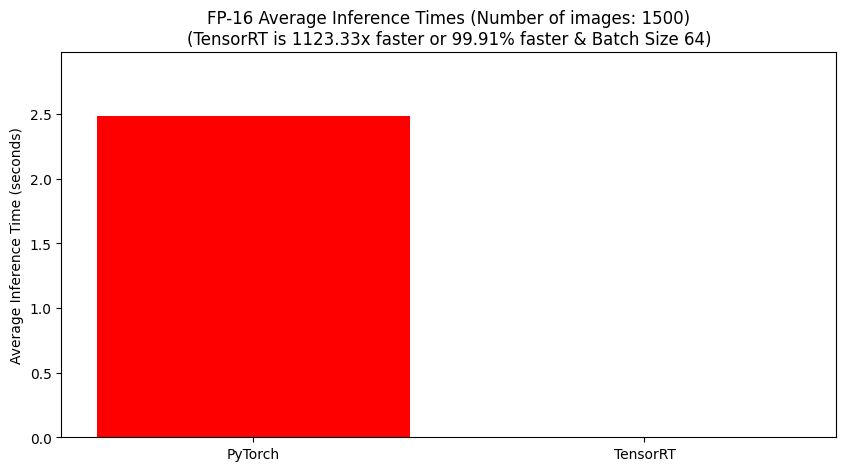

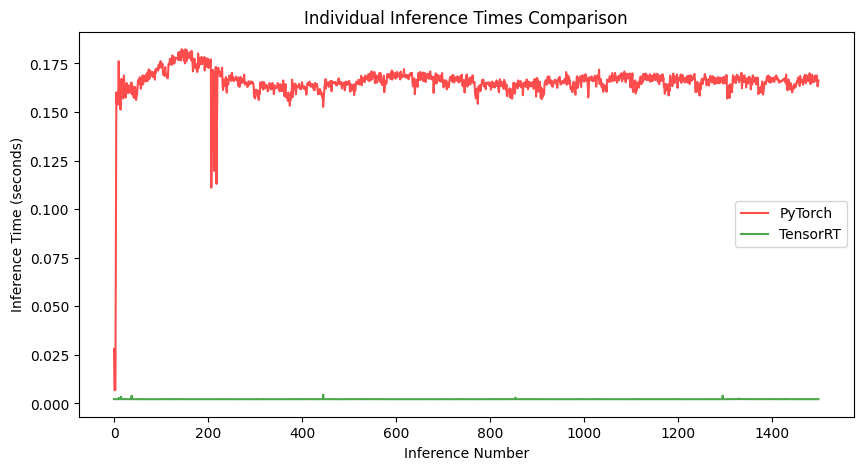

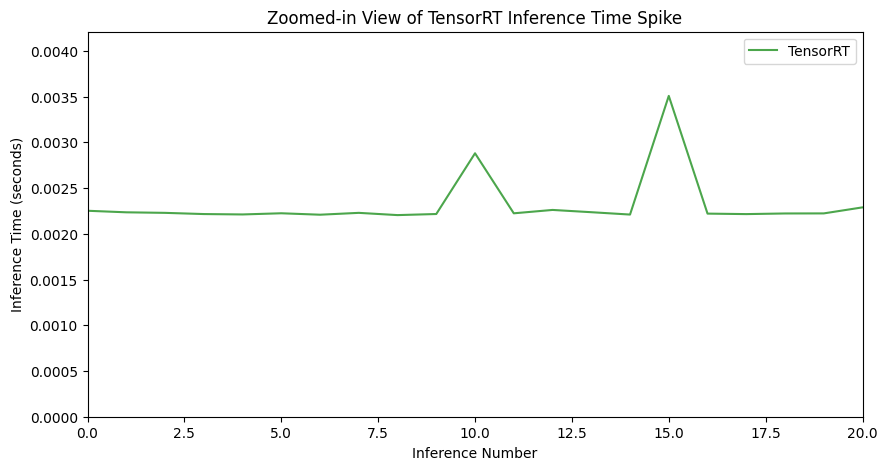

In [50]:
import matplotlib.pyplot as plt

# Assuming results from both PyTorch and TensorRT are stored
# results_pytorch and results_tensorrt are the dictionaries from previous code

# Extracting inference times
pytorch_inference_times = results_pytorch['Inference Times']
tensorrt_inference_times = results_tensorrt['Inference Times']

# Calculate average inference times
avg_time_pytorch = results_pytorch['Average Inference Time (PyTorch)']
avg_time_tensorrt = results_tensorrt['Average Inference Time (TensorRT)']

# Calculate speedup
speedup = avg_time_pytorch / avg_time_tensorrt
speedup_percentage = (1 - (avg_time_tensorrt / avg_time_pytorch)) * 100

# Plotting average inference times
labels = ['PyTorch', 'TensorRT']
avg_times = [avg_time_pytorch, avg_time_tensorrt]

plt.figure(figsize=(10, 5))
plt.bar(labels, avg_times, color=['red', 'green'])
plt.ylabel('Average Inference Time (seconds)')
if(FP_16_Precision == True):
    plt.title(f'FP-16 Average Inference Times (Number of images: {NUM_INFERENCES})\n(TensorRT is {speedup:.2f}x faster or {speedup_percentage:.2f}% faster & Batch Size {batch_size})')
else:
    plt.title(f'FP-32 Average Inference Times (Number of images: {NUM_INFERENCES})\n(TensorRT is {speedup:.2f}x faster or {speedup_percentage:.2f}% faster & Batch Size {batch_size})')
plt.ylim(0, max(avg_times) * 1.2)  # Set y-limit for better visibility
plt.show()

# Plotting individual inference times
plt.figure(figsize=(10, 5))
plt.plot(pytorch_inference_times, label='PyTorch', color='red', alpha=0.7)
plt.plot(tensorrt_inference_times, label='TensorRT', color='green', alpha=0.7)
plt.xlabel('Inference Number')
plt.ylabel('Inference Time (seconds)')
plt.title('Individual Inference Times Comparison')
plt.legend()
plt.show()

# Zoomed-in plot to highlight TensorRT's initial spike
plt.figure(figsize=(10, 5))
plt.plot(tensorrt_inference_times, label='TensorRT', color='green', alpha=0.7)

# Setting limits to zoom in on the first few inferences (e.g., first 20)
plt.xlim(0, 20)  # Adjust this if needed to match where the spike occurs
plt.ylim(0, max(tensorrt_inference_times[:20]) * 1.2)  # Zoom in on the y-axis
plt.xlabel('Inference Number')
plt.ylabel('Inference Time (seconds)')
plt.title('Zoomed-in View of TensorRT Inference Time Spike')
plt.legend()
plt.show()
